In [1]:
#r "nuget:ScottPlot, 5.0.36"

using System.Threading;
using System.Diagnostics;
using System.Collections.Concurrent;
using Microsoft.DotNet.Interactive.Formatting;

Queue<string> unsafeQueue = new();
BlockingCollection<string> blockColl = new();
ConcurrentQueue<string> queueSafe = new();

static ManualResetEvent manualResetEvent = new(false);

Stopwatch clock = new();

Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetImageHtml(1000, 400)), HtmlFormatter.MimeType);

Installed Packages ScottPlot, 5.0.36

Loading extensions from `/Users/macbook/.nuget/packages/skiasharp/2.88.8/interactive-extensions/dotnet/SkiaSharp.DotNet.Interactive.dll`

15278995,5



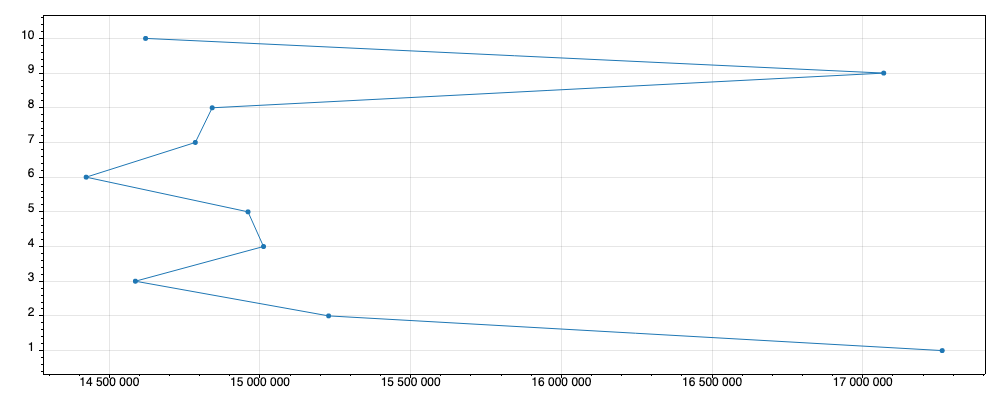

In [2]:
List<long> allTicks = new();

for (int k = 0; k < 10; k++)
{
    clock.Start();
    for (int i = 0; i < 1_000_000; i++)
        unsafeQueue.Enqueue("_message_");

    for (int i = 0; i < 1_000_000; i++)
        unsafeQueue.Dequeue();

    clock.Stop();

    allTicks.Add(clock.ElapsedTicks);
    clock.Reset();
}

Console.WriteLine(allTicks.Average());

ScottPlot.Plot plt = new();
plt.Add.Scatter(allTicks, Enumerable.Range(1, 10).ToList());

plt

213525512,4



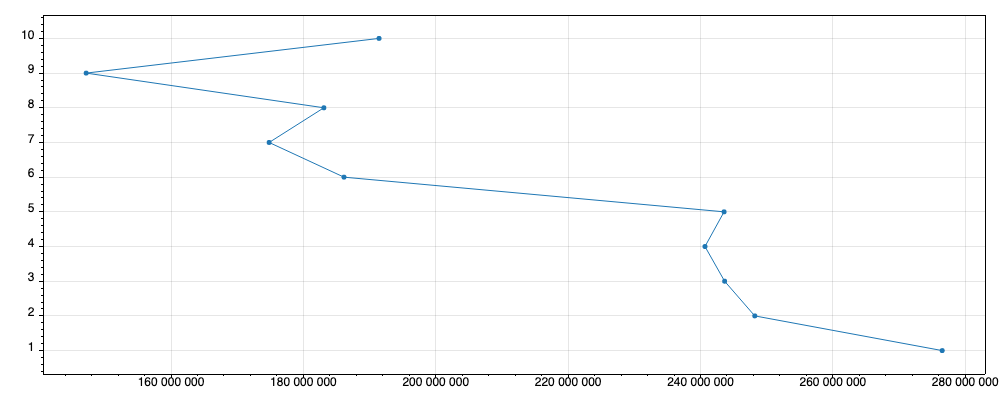

In [3]:
List<long> allTicks = new();

for (int k = 0; k < 10; k++)
{
    Task writeData = Task.Run(() => {
        manualResetEvent.WaitOne();
        clock.Start();

        for (int i = 0; i < 1_000_000; i++)
            blockColl.Add("_message_");
    });

    Task readData = Task.Run(() => {
        manualResetEvent.Set();
        
        for (int i = 0; i < 1_000_000; i++)
            blockColl.Take();

        clock.Stop();
        allTicks.Add(clock.ElapsedTicks);
    });

    Task.WaitAll(writeData, readData);
    manualResetEvent.Reset();
    clock.Reset();
}

Console.WriteLine(allTicks.Average());

ScottPlot.Plot plt = new();
plt.Add.Scatter(allTicks, Enumerable.Range(1, 10).ToList());

plt

11459396,2



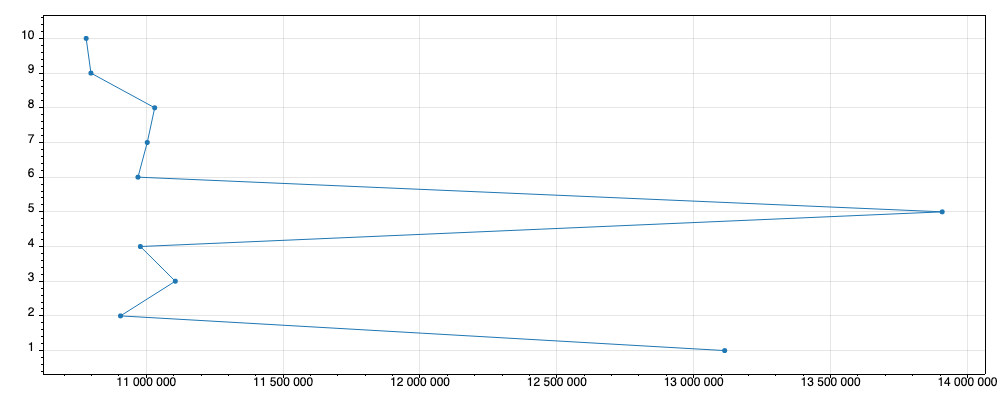

In [4]:
List<long> allTicks = new();

for (int k = 0; k < 10; k++)
{
    Task writeData = Task.Run(() => {
        manualResetEvent.WaitOne();
        clock.Start();

        for (int i = 0; i < 1_000_000; i++)
            queueSafe.Enqueue("_message_");
    });

    Task readData = Task.Run(() => {
        manualResetEvent.Set();
        
        for (int i = 0; i < 1_000_000; i++)
            queueSafe.TryDequeue(out string message);

        clock.Stop();
        allTicks.Add(clock.ElapsedTicks);
    });

    Task.WaitAll(writeData, readData);
    manualResetEvent.Reset();
    clock.Reset();
}

Console.WriteLine(allTicks.Average());

ScottPlot.Plot plt = new();
plt.Add.Scatter(allTicks, Enumerable.Range(1, 10).ToList());

plt

Самой быстрой потокобезопасной коллекцией является **ConcurrentQueue**, она показала скорость, которая на **21%** выше скорости непотокобезопасной очереди.

**Среднее кол-во тиков, за которое происходит запись и чтение в непотокобезопасной очереди: 102934 ticks**

**Среднее кол-во тиков, за которое происходит запись и чтение в BlockingCollection: 1251462 ticks**

**Среднее кол-во тиков, за которое происходит запись и чтение в ConcurrentQueue: 85656 ticks**